# Ensemble

## Environment Setup

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import shutil
import numpy as np
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import Model
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
import seaborn as sns
from tensorflow.keras import regularizers
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CLASSES = ['Paul_Gauguin',
 'Edgar_Degas',
 'Vincent_van_Gogh',
 'Albrecht_Dürer',
 'Pablo_Picasso',
 'Titian',
 'Francisco_Goya',
 'Marc_Chagall',
 'Pierre-Auguste_Renoir',
 'Alfred_Sisley',
 'Rembrandt']

TRAIN_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/train'
TEST_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/test'
VAL_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/val'

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 47

### Dataset Loading

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)


val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)


Found 3004 files belonging to 11 classes.
Found 656 files belonging to 11 classes.
Found 639 files belonging to 11 classes.


## Ensemble Model

In [ ]:
class Ensemble:

  def __init__(self):
      
      self.predicted_test_scores = []
      self.true_test_labels = []
      self.vgg_model = None
      self.resnet_model = None
      self.inception_model = None
      self.from_scratch_model = None
      self.ensemble_prediction = []
      self.ensemble_weighted_prediction = []

  def load_models(self):
    try:
      self.vgg_model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/VGG16Weights/NoDropout.h5', compile=False)
      self.resnet_model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/ResNet50Weights/Dropout.h5', compile=False)
      self.inception_model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/InceptionNet/Inception_NoDropout.h5', compile=False)
      self.from_scratch_model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/CNN_from_scratch/9_CNN_Double_inception.h5', compile=False)
    except FileNotFoundError:
        print("Model not found, wrong file path")
      
  def predict(self, test_images):
    vgg_model_test = self.vgg_model.predict(test_images)
    resnet_model_test = self.resnet_model.predict(test_images)
    inception_model_test = self.inception_model.predict(test_images)
    from_scratch_model_test = self.from_scratch_model.predict(test_images)
    self.predicted_test_scores = [vgg_model_test, resnet_model_test, inception_model_test, from_scratch_model_test]
    self.true_test_labels = tf.concat([label for image, label in test_images], axis = 0)

  def compute_ensemble_prediction(self):
    self.predicted_test_scores = np.array(self.predicted_test_scores)
    ensemble_scores = np.mean(self.predicted_test_scores, axis=0)
    self.ensemble_prediction = np.argmax(ensemble_scores, axis=-1) # argmax across classes
    self.evaluate_model(self.true_test_labels, self.ensemble_prediction)

  def weighted_ensemble_prediction(self, weights):
    self.predicted_test_scores = np.array(self.predicted_test_scores)
    weight_array = np.array(weights)   # defining a 1D array
    norm = np.linalg.norm(weight_array)     # To find the norm of the array
    normalized_array = weight_array/norm  # Formula used to perform array normalization
    weighted_scores = np.average(self.predicted_test_scores, axis = 0, weights = normalized_array)
    self.ensemble_weighted_prediction = np.argmax(weighted_scores, axis=-1) # argmax across classes
    self.evaluate_model(self.true_test_labels, self.ensemble_weighted_prediction)

  def weighted_ensemble_prediction_GA(self, weights):
    self.predicted_test_scores = np.array(self.predicted_test_scores)
    np_weights = np.array(weights)
    weighted_scores = np.average(self.predicted_test_scores, axis = 0, weights = np_weights)
    self.ensemble_weighted_prediction = np.argmax(weighted_scores, axis=-1) # argmax across classes
    return metrics.accuracy_score(self.true_test_labels, self.ensemble_weighted_prediction)

  def evaluate_model(self, true_labels, predicted_labels):
    print("Accuracy on test set: " +str(metrics.accuracy_score(true_labels, predicted_labels)))
    print(metrics.classification_report(true_labels, predicted_labels, target_names=CLASSES, digits=4))
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)


21/21 [==============================] - 1s 61ms/step
Accuracy on test set: 0.8597560975609756
                       precision    recall  f1-score   support

         Paul_Gauguin     0.9434    1.0000    0.9709        50
          Edgar_Degas     0.9000    0.9000    0.9000        40
     Vincent_van_Gogh     0.8559    0.9528    0.9018       106
       Albrecht_Dürer     0.9000    0.6000    0.7200        45
        Pablo_Picasso     1.0000    0.8378    0.9118        37
               Titian     0.8966    0.7761    0.8320        67
       Francisco_Goya     0.7872    0.7708    0.7789        48
         Marc_Chagall     0.8182    0.7059    0.7579        51
Pierre-Auguste_Renoir     0.7609    0.8750    0.8140        40
        Alfred_Sisley     0.7727    0.8718    0.8193        39
            Rembrandt     0.8621    0.9398    0.8993       133

             accuracy                         0.8598       656
            macro avg     0.8634    0.8391    0.8460       656
         weighted avg

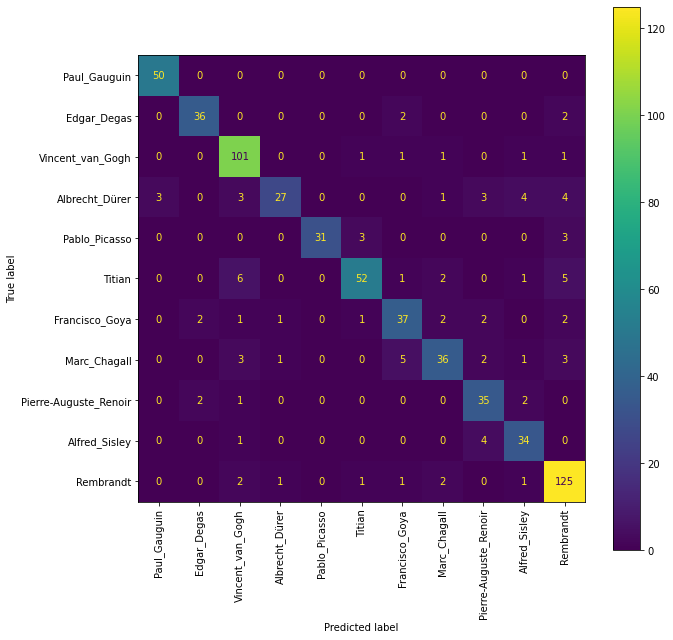

In [ ]:
ensemble = Ensemble()
ensemble.load_models()
ensemble.predict(test_images)
ensemble.compute_ensemble_prediction()

## Genetic Algorithm 

In [ ]:
MODEL_NUM = 4
POPSIZE = 50
GENERATIONS = 10
MUTATION_PROB = 0.3
CROSSOVER_PROB = 0.7

In [ ]:
class GeneticAlgorithmWeights:
  
  def __init__(self, models_num, pop_size, generations, mutation_prob, crossover_prob):
    self.models_num = models_num
    self.popsize = pop_size
    self.generations = generations
    self.mutation_prob = mutation_prob
    self.crossover_prob = crossover_prob
    self.population = []
    self.scores = []
  
  def mutation(self, chromosome):
    #Swap mutation
    gene1 = random.randint(0, len(chromosome)-1)
    gene2 = random.randint(0, len(chromosome)-1)
    while gene2 == gene1:
      gene2 = random.randint(0, len(chromosome)-1)
    
    chromosome[gene1], chromosome[gene2] = chromosome[gene2], chromosome[gene1]
    #normalization
    for i in range(len(chromosome)):
      chromosome[i] = chromosome[i]/sum(chromosome)
    return chromosome

  def crossover(self, parent1, parent2):
    #One-point crossover
    index = random.randint(1, len(parent1)-1)
    children1 = []
    children2 = []
    for i in range(len(parent1)):
      if i < index:
        children1.append(parent1[i])
        children2.append(parent2[i])
      else:
        children1.append(parent2[i])
        children2.append(parent1[i])
    #normalization
    for i in range(len(children1)):
      children1[i] = children1[i]/sum(children1)
      children2[i] = children2[i]/sum(children2)
    return children1, children2
  
  def generate_population(self):
    self.population = []
    for i in range(self.popsize):
      chromosome = []
      for index in range(self.models_num):
        chromosome.append(random.random())
      #normalization
      for index in range(self.models_num):
        chromosome[index] = chromosome[index]/sum(chromosome)
      self.population.append(chromosome)
  
  def turnament_selection(self, k):
    selected_indexes = random.sample(range(self.popsize), k)
    selected_parents = [self.population[index] for index in selected_indexes]
    selected_scores = [self.scores[index] for index in selected_indexes]

    best_parent = None
    best_score = -1
    for i in range(k):
      if selected_scores[i] > best_score:
        best_score = selected_scores[i]
        best_parent = selected_parents[i]
    
    return best_parent

  def fitness(self, weights, ensemble):
    return ensemble.weighted_ensemble_prediction_GA(weights)
  
  def compute_score(self, ensemble):
    self.scores = []
    for i in range(self.popsize):
      self.scores.append(self.fitness(self.population[i], ensemble))

  def execute_GA(self, ensemble):

    self.generate_population()
    best_chromosome = []
    best_fit = 0
    for i in range(self.generations):
      self.compute_score(ensemble)
      new_best_this_gen = False
      #find best chromosome for each generation
      for j in range(self.popsize):
        if self.scores[j] > best_fit:
          best_fit = self.scores[j]
          best_chromosome = self.population[j]
          new_best_this_gen = True
      if new_best_this_gen:
        print("Generation " + str(i) + ": Best Chromosome = " + str(best_chromosome) + " Best Fitness = " + str(best_fit))
      else:
        print("Generation " + str(i) + " did not find a better solution")
      #choose parents
      selected_parents = []
      for n in range(self.popsize):
        selected_parents.append(self.turnament_selection(5))
      #compute offsprings
      new_population = []
      for m in range(0, self.popsize, 2):
        parent1 = selected_parents[m]
        parent2 = selected_parents[m+1]
        if random.random() < self.crossover_prob:
          children1, children2 = self.crossover(parent1, parent2)
          if random.random() < self.mutation_prob:
            children1 = self.mutation(children1)
            children2 = self.mutation(children2)
        else:
          children1 = parent1
          children2 = parent2
        
        new_population.append(children1)
        new_population.append(children2)
      #new generation
      self.population = []
      self.population = new_population

    print("Best overall results: Best Chromosome = " + str(best_chromosome) + " Best Fitness = " + str(best_fit))
    return best_chromosome, best_fit

In [ ]:
ensemble = Ensemble()
ensemble.load_models()
ensemble.predict(test_images)


21/21 [==============================] - 1s 53ms/step


In [ ]:
ga = GeneticAlgorithmWeights(MODEL_NUM, POPSIZE, GENERATIONS, MUTATION_PROB, CROSSOVER_PROB)

Genetic iteration number 0
Generation 0: Best Chromosome = [0.28671234881964286, 0.26973718119258994, 0.40314503946580416, 0.14242062097537037] Best Fitness = 0.8597560975609756
Generation 1: Best Chromosome = [0.2917229598177559, 0.30611014014855714, 0.24146639631143102, 0.14507252981009294] Best Fitness = 0.864329268292683
Generation 2: Best Chromosome = [0.22368530645284426, 0.3295203094989851, 0.2083477191456502, 0.2544877084257318] Best Fitness = 0.8658536585365854
Generation 3 did not find a better solution
Generation 4 did not find a better solution
Generation 5 did not find a better solution
Generation 6 did not find a better solution
Generation 7: Best Chromosome = [0.3051782747123296, 0.3158760806410364, 0.14830577243851845, 0.2227892762894832] Best Fitness = 0.8673780487804879
Generation 8 did not find a better solution
Generation 9 did not find a better solution
Best overall results: Best Chromosome = [0.3051782747123296, 0.3158760806410364, 0.14830577243851845, 0.222789276

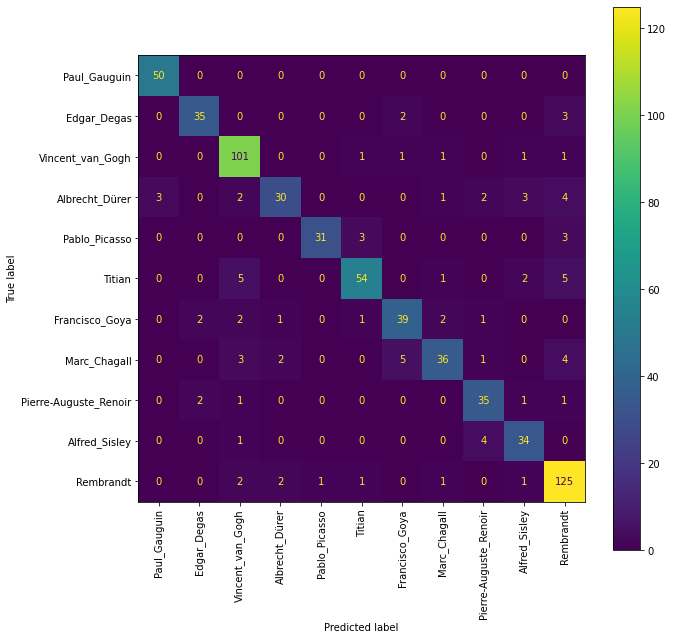

In [ ]:
best_chromosome_over_genetic_iter = []
best_fit_over_genetic_iter = 0
for i in range(15):
  print("Genetic iteration number " + str(i))
  best_chromosome, best_fit = ga.execute_GA(ensemble)
  if best_fit > best_fit_over_genetic_iter:
    best_fit_over_genetic_iter = best_fit
    best_chromosome_over_genetic_iter = best_chromosome
  print("---------------------------------------------------------------------------")
  print("\n")
ensemble.weighted_ensemble_prediction(best_chromosome_over_genetic_iter)